![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Transfer Learning with Pre-trained Models

In our previous notebooks, we built CNN models from scratch and explored data augmentation. While these techniques are valuable, training deep networks from scratch requires significant computational resources and large datasets. 

**Transfer Learning** offers a powerful alternative: we can leverage models that have already been trained on massive datasets and adapt them for our specific task.

## What is Transfer Learning?

Transfer learning involves taking a model that has been pre-trained on a large dataset (like ImageNet with 1.4 million images) and adapting it for a new, related task. The key insight is that the features learned by these models (edges, shapes, textures, objects) are often useful across many different computer vision tasks.

## Benefits of Transfer Learning:

1. **Faster Training**: Start with learned features instead of random weights
2. **Better Performance**: Especially with limited data
3. **Less Data Required**: Can achieve good results with smaller datasets
4. **Computational Efficiency**: Don't need to train millions of parameters from scratch

## EfficientNetB5

For this notebook, we'll use **EfficientNetB5**, a state-of-the-art convolutional neural network that achieves excellent accuracy while being computationally efficient. EfficientNetB5:

- Was trained on ImageNet (1.4M images, 1000 classes)
- Uses compound scaling to balance network depth, width, and resolution
- Achieves top-1 accuracy of ~83.6% on ImageNet
- Has ~30 million parameters

Let's see how this powerful pre-trained model performs on our bee vs wasp classification task!

## 1. Import the libraries we will use

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from PIL import Image

# For EfficientNet, we'll use timm (PyTorch Image Models)
import timm

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# Many functions are moved to helpers_01.py to keep this file clean.
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

[rank: 0] Seed set to 42


42

## 2. Check PyTorch installation and available models

In [2]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

# Check if timm is available and show EfficientNet models
try:
    print(f'\nTimm version: {timm.__version__}')
    # List available EfficientNet models
    efficientnet_models = [model for model in timm.list_models() if 'efficientnet' in model and 'b5' in model]
    print(f'Available EfficientNetB5 variants: {efficientnet_models[:5]}')  # Show first 5
except ImportError:
    print("Timm not available. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'timm'])
    import timm
    print(f'Timm installed successfully: {timm.__version__}')

Pytorch version: 2.7.1+cu128
  Should be "True" if Pytorch was built for GPU: True
  Available GPU: NVIDIA B200

Timm version: 1.0.15
Available EfficientNetB5 variants: ['efficientnet_b5', 'efficientnet_h_b5', 'efficientnet_x_b5', 'tf_efficientnet_b5']


## 3. Load and prepare the data

We'll use the same bee vs wasp dataset, but this time we need to adjust our data preprocessing to match what EfficientNetB5 expects. Pre-trained models typically expect specific input sizes and normalization.

Found data at data/bee_vs_wasp_reduced.
Using 4 workers for data loading.
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 16.
  - Resizing input images to: (224, 224, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Augmentation strength: light
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
The classes in your dataset are: ['bee', 'other_insect', 'other_noinsect', 'wasp']


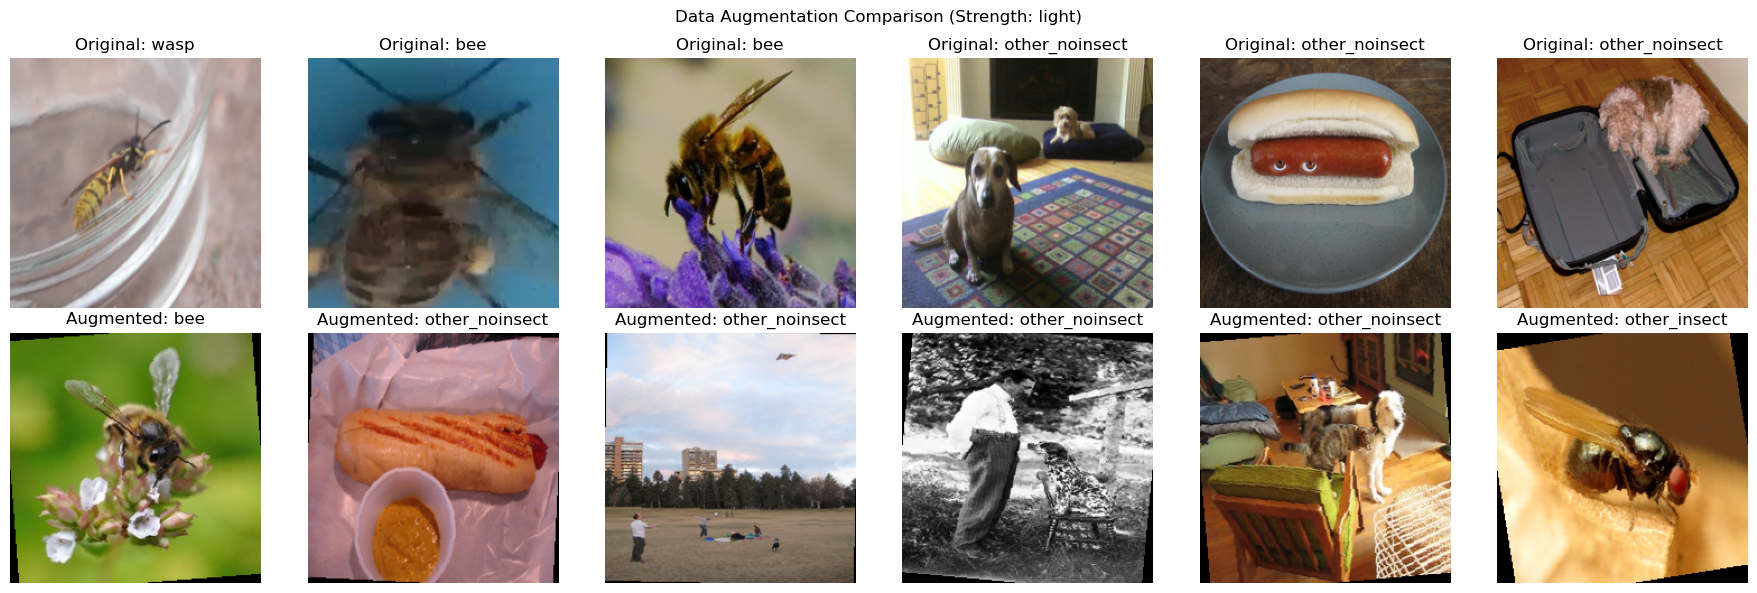

In [3]:
# Get the data path
data_path = helpers_01.manage_data(folder_name='bee_vs_wasp_reduced')

# Set the number of workers for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

# EfficientNetB5 expects 224x224 images (higher resolution than our previous models)
# This is important for transfer learning - use the same input size as pre-training
data_module = helpers_01.load_display_data_augmented(
    data_path, 
    batch_size=16,  # Smaller batch size due to larger images and model
    shape=(224, 224, 3),  # EfficientNetB5 standard input size
    show_pictures=True,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength='light'  # Start with light augmentation
)

## 4. Understanding Transfer Learning Approaches

There are several ways to use a pre-trained model:

1. **Feature Extraction**: Freeze the pre-trained layers and only train a new classifier
2. **Fine-tuning**: Allow some or all pre-trained layers to be updated with a small learning rate
3. **Gradual Unfreezing**: Start with frozen layers, then gradually unfreeze more layers

Let's implement these different approaches and compare their performance.

### 4.1 Feature Extraction (Frozen Backbone)

First, let's try feature extraction where we freeze the EfficientNetB5 backbone and only train a new classifier head.

TRAINING EFFICIENTNETB5 - FEATURE EXTRACTION (FROZEN BACKBONE)
Backbone (efficientnet_b5) frozen for feature extraction


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Model created with 29,391,924 total parameters
Trainable parameters: 1,051,140


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 28.3 M | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 1.1 M  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
1.1 M     Trainable params
28.3 M    Non-trainable params
29.4 M    Total params
117.568   Total estimated model params size (MB)
800       Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Frozen backbone model evaluation:


SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8910890817642212
        test_loss           0.2883596122264862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 9 points
Processing tag: val_acc
Found val acc: val_acc with 9 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 9 points
Processing tag: train_acc
Found train acc: train_acc with 9 points

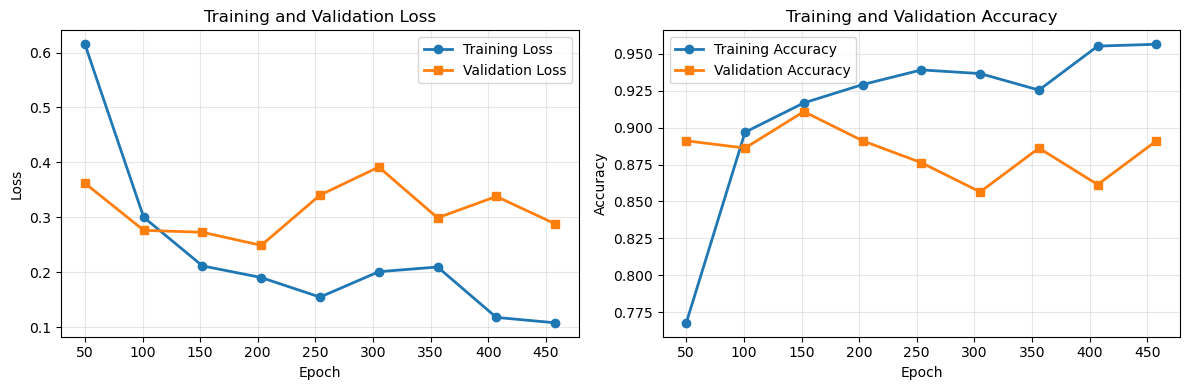

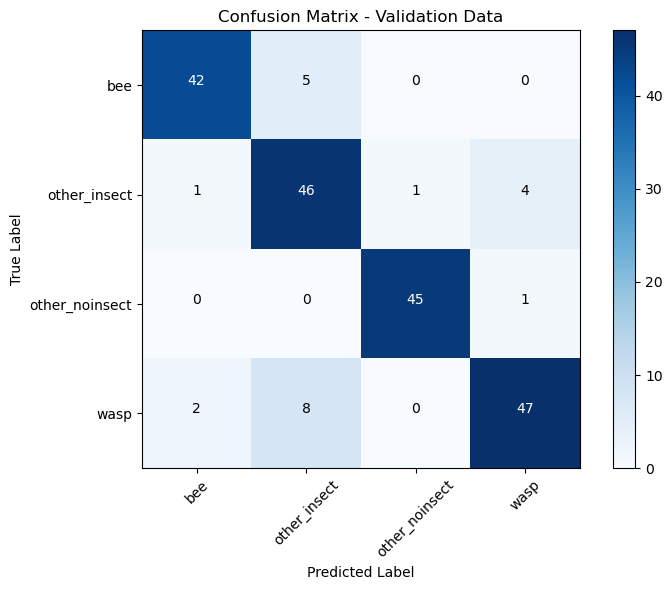


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.933, Recall=0.894, F1=0.913
   other_insect: Precision=0.780, Recall=0.885, F1=0.829
 other_noinsect: Precision=0.978, Recall=0.978, F1=0.978
           wasp: Precision=0.904, Recall=0.825, F1=0.862


In [4]:
# Train EfficientNetB5 with frozen backbone (feature extraction)
print("="*60)
print("TRAINING EFFICIENTNETB5 - FEATURE EXTRACTION (FROZEN BACKBONE)")
print("="*60)

frozen_model, frozen_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,  # Higher learning rate for new classifier head
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    model_name='efficientnet_b5',
    freeze_backbone=True,  # Freeze pre-trained layers
    dropout_rate=0.3
)

print("\nFrozen backbone model evaluation:")
frozen_results = helpers_01.test_model(data_module, frozen_model, frozen_trainer)

### 4.2 Fine-tuning (Unfrozen Backbone)

Now let's try fine-tuning where we allow the entire model to be updated, but with different learning rates for different parts.

TRAINING EFFICIENTNETB5 - FINE-TUNING (UNFROZEN BACKBONE)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Backbone (efficientnet_b5) unfrozen for fine-tuning
Model created with 29,391,924 total parameters
Trainable parameters: 29,391,924


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 28.3 M | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 1.1 M  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.568   Total estimated model params size (MB)
800       Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fine-tuned model evaluation:


SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9356435537338257
        test_loss           0.21636340022087097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 10 points
Processing tag: val_acc
Found val acc: val_acc with 10 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 10 points
Processing tag: train_acc
Found train acc: train_acc with 10 p

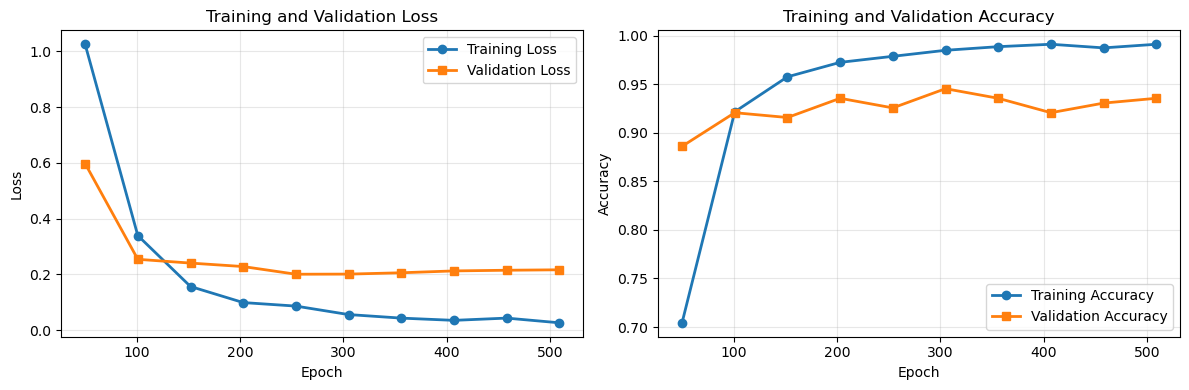

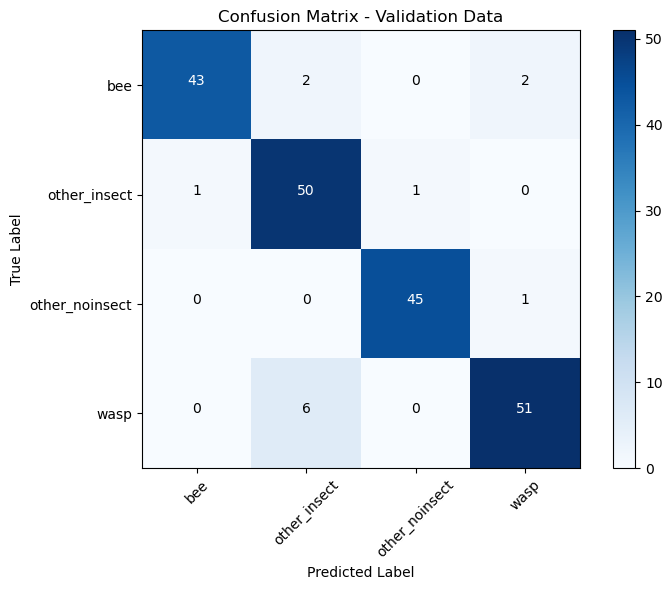


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.977, Recall=0.915, F1=0.945
   other_insect: Precision=0.862, Recall=0.962, F1=0.909
 other_noinsect: Precision=0.978, Recall=0.978, F1=0.978
           wasp: Precision=0.944, Recall=0.895, F1=0.919


In [5]:
# Train EfficientNetB5 with fine-tuning (unfrozen backbone)
print("="*60)
print("TRAINING EFFICIENTNETB5 - FINE-TUNING (UNFROZEN BACKBONE)")
print("="*60)

finetuned_model, finetuned_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.0001,  # Lower learning rate for fine-tuning
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    model_name='efficientnet_b5',
    freeze_backbone=False,  # Allow all layers to be updated
    dropout_rate=0.3
)

print("\nFine-tuned model evaluation:")
finetuned_results = helpers_01.test_model(data_module, finetuned_model, finetuned_trainer)

## 5. Comparing Transfer Learning vs Training from Scratch

Let's compare our transfer learning results with training from scratch to see the benefits.

TRAINING SIMPLE CNN FROM SCRATCH (FOR COMPARISON)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 25.7 M | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



From-scratch model evaluation:


SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5742574334144592
        test_loss           1.1325575113296509
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 10 points
Processing tag: val_acc
Found val acc: val_acc with 10 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 10 points
Processing tag: train_acc
Found train acc: train_acc with 10 po

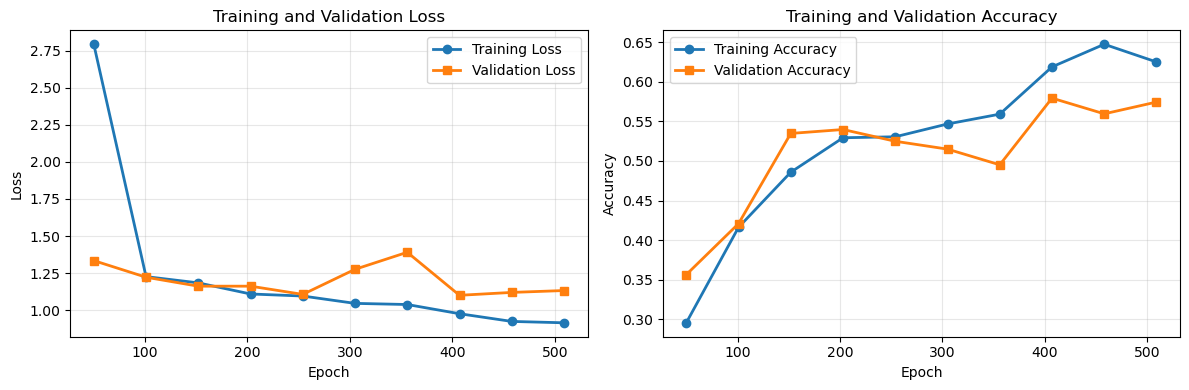

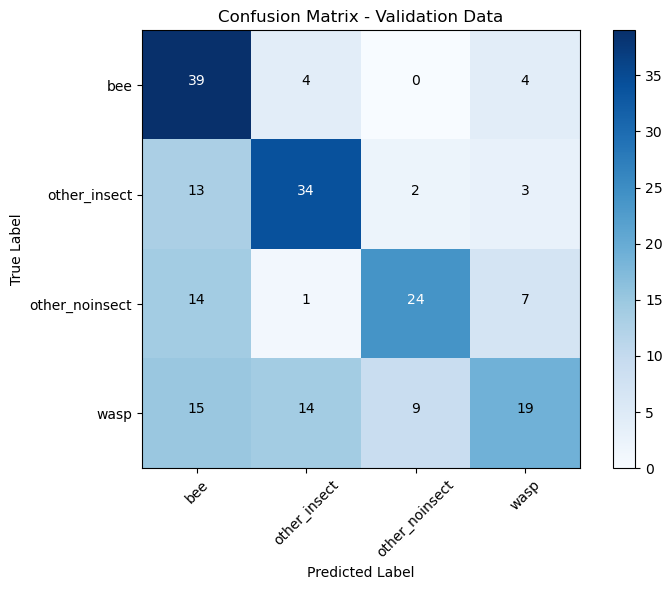


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.481, Recall=0.830, F1=0.609
   other_insect: Precision=0.642, Recall=0.654, F1=0.648
 other_noinsect: Precision=0.686, Recall=0.522, F1=0.593
           wasp: Precision=0.576, Recall=0.333, F1=0.422


In [6]:
# For comparison, let's also train our simple CNN from scratch with the same data
print("="*60)
print("TRAINING SIMPLE CNN FROM SCRATCH (FOR COMPARISON)")
print("="*60)

scratch_model, scratch_trainer = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    input_shape=(3, 224, 224),  # Same input size for fair comparison
    dropout_rate=0.5,
    conv_padding=1
)

print("\nFrom-scratch model evaluation:")
scratch_results = helpers_01.test_model(data_module, scratch_model, scratch_trainer)

## 6. Results Comparison and Analysis

TRANSFER LEARNING RESULTS COMPARISON
Model                          Test Accuracy   Training Time  
------------------------------------------------------------
EfficientNetB5 (Frozen)        0.891           ~10 epochs     
EfficientNetB5 (Fine-tuned)    0.936           ~10 epochs     
Simple CNN (From Scratch)      0.574           ~10 epochs     


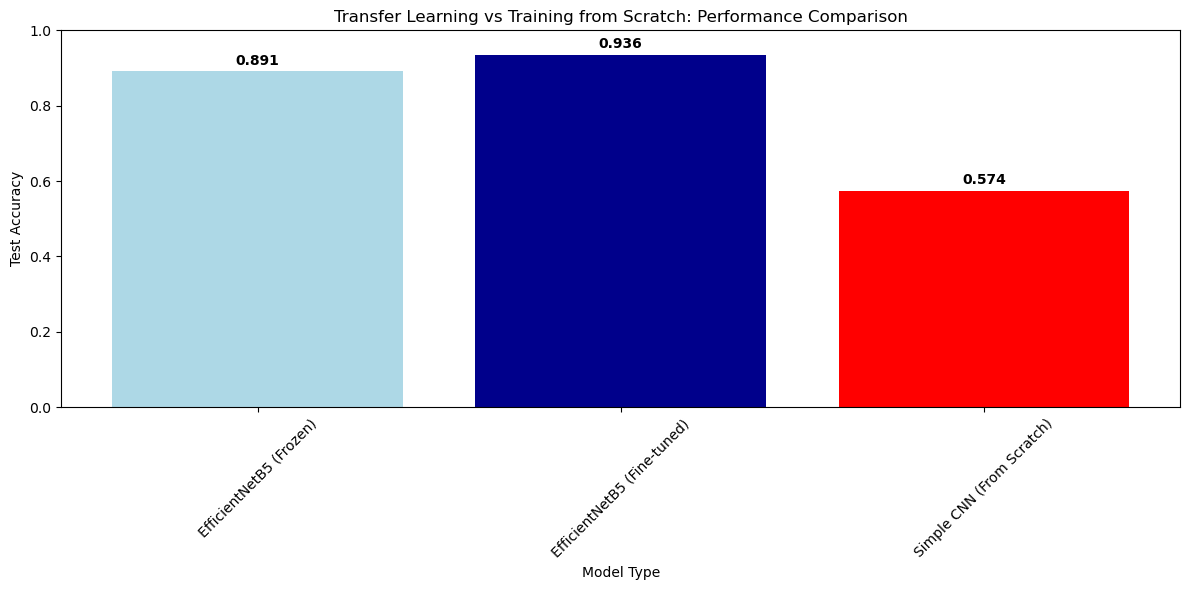


KEY OBSERVATIONS:
1. Transfer learning typically achieves higher accuracy faster
2. Fine-tuning often outperforms feature extraction
3. Pre-trained models start with meaningful features
4. Training from scratch requires more data and time to converge
5. EfficientNetB5 benefits from ImageNet's diverse feature representations


In [7]:
# Extract test accuracies from each model
models_summary = {
    'EfficientNetB5 (Frozen)': frozen_results[0]['test_acc'],
    'EfficientNetB5 (Fine-tuned)': finetuned_results[0]['test_acc'],
    'Simple CNN (From Scratch)': scratch_results[0]['test_acc']
}

print("="*60)
print("TRANSFER LEARNING RESULTS COMPARISON")
print("="*60)
print(f"{'Model':<30} {'Test Accuracy':<15} {'Training Time':<15}")
print("-" * 60)

for model_name, accuracy in models_summary.items():
    print(f"{model_name:<30} {accuracy:<15.3f} {'~10 epochs':<15}")

# Create a bar plot comparing accuracies
plt.figure(figsize=(12, 6))
model_names = list(models_summary.keys())
accuracies = list(models_summary.values())

colors = ['lightblue', 'darkblue', 'red']
bars = plt.bar(model_names, accuracies, color=colors)
plt.title('Transfer Learning vs Training from Scratch: Performance Comparison')
plt.ylabel('Test Accuracy')
plt.xlabel('Model Type')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY OBSERVATIONS:")
print("="*60)
print("1. Transfer learning typically achieves higher accuracy faster")
print("2. Fine-tuning often outperforms feature extraction")
print("3. Pre-trained models start with meaningful features")
print("4. Training from scratch requires more data and time to converge")
print("5. EfficientNetB5 benefits from ImageNet's diverse feature representations")

## 7. Analyzing What the Model Learned

Let's examine what features the pre-trained EfficientNetB5 model is using for our bee vs wasp classification.

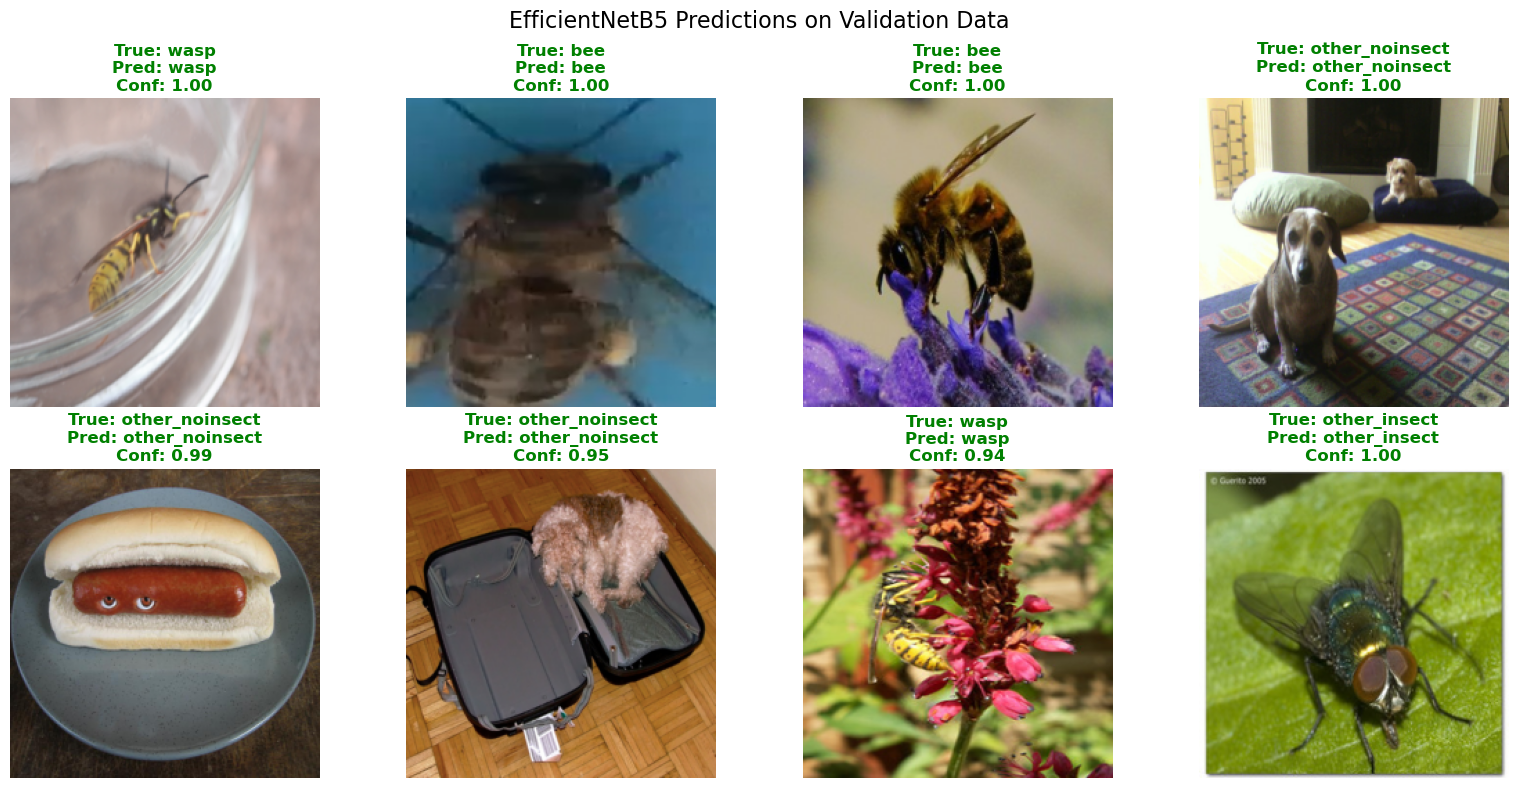

In [8]:
# Let's visualize some predictions to understand what the model learned
finetuned_model.eval()

# Get a batch of validation images
val_loader = data_module.val_dataloader()
images, labels = next(iter(val_loader))

# Get class names
class_names, _ = data_module.get_class_info()

# Move to same device as model
device = next(finetuned_model.parameters()).device
images = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = finetuned_model(images)
    probabilities = F.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(outputs, dim=1)

# Visualize first 8 predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    # Convert image back to displayable format
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    # Get prediction info
    true_class = class_names[labels[i]]
    pred_class = class_names[predicted_classes[i]]
    confidence = probabilities[i, predicted_classes[i]].item()
    
    # Determine color based on correctness
    color = 'green' if labels[i] == predicted_classes[i] else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('EfficientNetB5 Predictions on Validation Data', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Advanced Transfer Learning: Model Comparison

Let's explore how different pre-trained models perform on our task.

COMPARING DIFFERENT PRE-TRAINED MODELS
Training EfficientNetB3 (smaller model)...
Backbone (efficientnet_b3) unfrozen for fine-tuning


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 10.7 M | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 788 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.5 M    Trainable params
0 

Model created with 11,485,228 total parameters
Trainable parameters: 11,485,228


SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9108911156654358
        test_loss           0.30846184492111206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 5 points
Processing tag: val_acc
Found val acc: val_acc with 5 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 5 points
Processing tag: train_acc
Found train acc: train_acc with 5 point

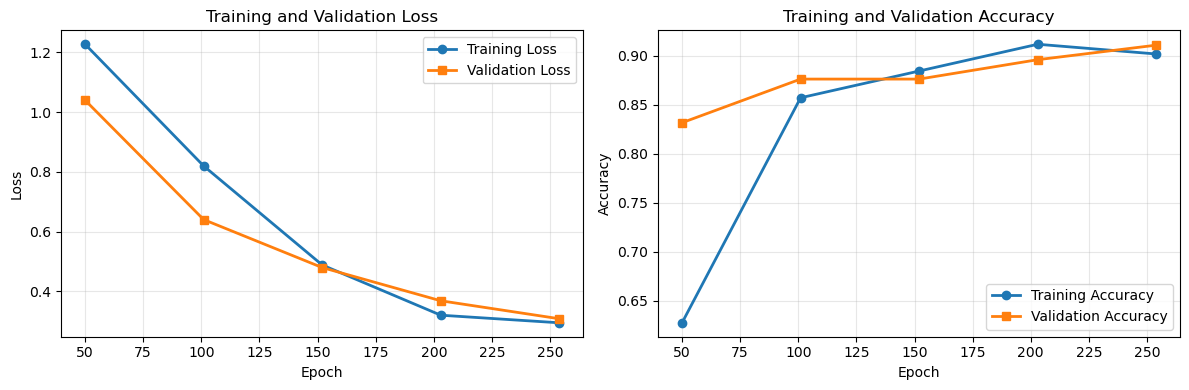

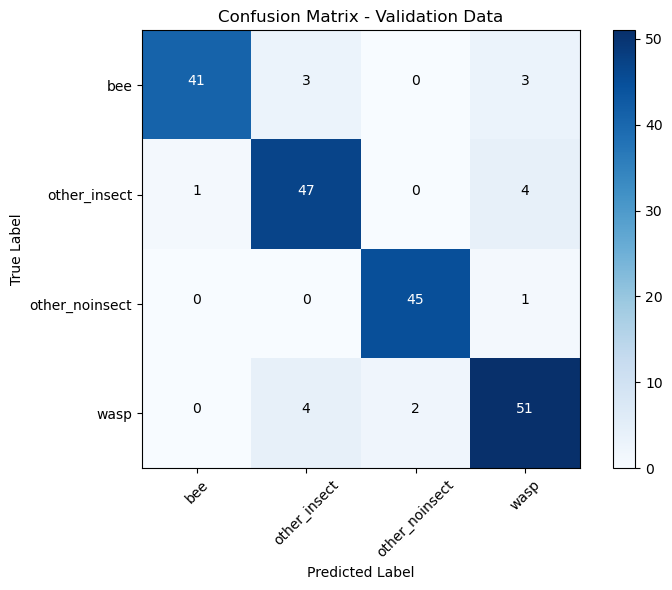


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.976, Recall=0.872, F1=0.921
   other_insect: Precision=0.870, Recall=0.904, F1=0.887
 other_noinsect: Precision=0.957, Recall=0.978, F1=0.968
           wasp: Precision=0.864, Recall=0.895, F1=0.879

Model Comparison Summary:
----------------------------------------------------------------------
Model           Accuracy   Parameters      Input Size  
----------------------------------------------------------------------
EfficientNetB3  0.911      ~12M parameters 224x224     
EfficientNetB5  0.936      ~30M parameters 224x224     
Simple CNN      0.574      ~100K parameters 224x224     


In [9]:
# Compare different pre-trained models
print("="*60)
print("COMPARING DIFFERENT PRE-TRAINED MODELS")
print("="*60)

# Test with a smaller EfficientNet model for comparison
print("Training EfficientNetB3 (smaller model)...")
efficientb3_model, efficientb3_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.0001,
    max_epochs=5,  # Fewer epochs for demonstration
    accelerator='auto',
    devices='auto',
    model_name='efficientnet_b3',
    freeze_backbone=False,
    dropout_rate=0.3
)

efficientb3_results = helpers_01.test_model(data_module, efficientb3_model, efficientb3_trainer)

# Compare model sizes and performance
model_comparison = {
    'EfficientNetB3': {
        'accuracy': efficientb3_results[0]['test_acc'],
        'params': '~12M parameters',
        'input_size': '224x224'
    },
    'EfficientNetB5': {
        'accuracy': finetuned_results[0]['test_acc'],
        'params': '~30M parameters', 
        'input_size': '224x224'
    },
    'Simple CNN': {
        'accuracy': scratch_results[0]['test_acc'],
        'params': '~100K parameters',
        'input_size': '224x224'
    }
}

print("\nModel Comparison Summary:")
print("-" * 70)
print(f"{'Model':<15} {'Accuracy':<10} {'Parameters':<15} {'Input Size':<12}")
print("-" * 70)

for model_name, info in model_comparison.items():
    print(f"{model_name:<15} {info['accuracy']:<10.3f} {info['params']:<15} {info['input_size']:<12}")

## 9. Conclusion and Best Practices

### Key Takeaways from Transfer Learning:

1. **Dramatic Performance Improvement**: Pre-trained models typically achieve much better accuracy than training from scratch, especially with limited data.

2. **Faster Convergence**: Transfer learning models converge much faster since they start with meaningful features.

3. **Resource Efficiency**: Requires less computational resources and training time.

4. **Model Size vs Performance**: Larger models (EfficientNetB5) generally perform better than smaller ones (EfficientNetB3), but at the cost of computational requirements.

### Best Practices for Transfer Learning:

#### **Choosing the Right Approach:**
- **Feature Extraction**: When your dataset is small and similar to the pre-training dataset
- **Fine-tuning**: When you have sufficient data and computational resources
- **Gradual Unfreezing**: For very large models or when training resources are limited

#### **Learning Rate Strategy:**
- Use **lower learning rates** (0.0001-0.001) for fine-tuning pre-trained layers
- Use **higher learning rates** (0.001-0.01) for new classifier heads
- Consider **different learning rates** for different parts of the model

#### **Data Preprocessing:**
- **Match the preprocessing** used during pre-training (normalization, input size)
- **Use appropriate input sizes** (224x224 for most ImageNet models)
- **Apply similar augmentations** that were used during pre-training

#### **Model Selection:**
- **EfficientNet**: Great balance of accuracy and efficiency
- **ResNet**: Robust and widely used
- **Vision Transformer (ViT)**: State-of-the-art for many tasks

### When to Use Transfer Learning:

✅ **Ideal for:**
- Small to medium datasets
- Limited computational resources
- Quick prototyping and development
- Computer vision tasks similar to ImageNet

❌ **Consider alternatives when:**
- Very large custom datasets available
- Domain is very different from pre-training data
- Specific architectural requirements

Transfer learning is one of the most powerful techniques in modern deep learning, enabling remarkable performance improvements with relatively little additional effort!